# Face Generation
In this project, you'll use generative adversarial networks to generate new images of faces.
### Get the Data
You'll be using two datasets in this project:
- MNIST
- CelebA

Since the celebA dataset is complex and you're doing GANs in a project for the first time, we want you to test your neural network on MNIST before CelebA.  Running the GANs on MNIST will allow you to see how well your model trains sooner.

If you're using [FloydHub](https://www.floydhub.com/), set `data_dir` to "/input" and use the [FloydHub data ID](http://docs.floydhub.com/home/using_datasets/) "R5KrjnANiKVhLWAkpXhNBe".

In [1]:
data_dir = './data'

# FloydHub - Use with data ID "R5KrjnANiKVhLWAkpXhNBe"
#data_dir = '/input'


"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import helper

helper.download_extract('mnist', data_dir)
helper.download_extract('celeba', data_dir)

Found mnist Data
Found celeba Data


## Explore the Data
### MNIST
As you're aware, the [MNIST](http://yann.lecun.com/exdb/mnist/) dataset contains images of handwritten digits. You can view the first number of examples by changing `show_n_images`. 

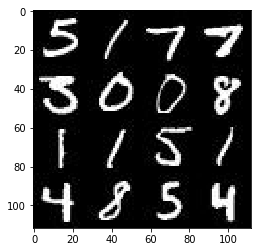

In [2]:
show_n_images = 20

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
%matplotlib inline
import os
from glob import glob
from matplotlib import pyplot

mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'mnist/*.jpg'))[:show_n_images], 28, 28, 'L')
pyplot.imshow(helper.images_square_grid(mnist_images, 'L'), cmap='gray')

### CelebA
The [CelebFaces Attributes Dataset (CelebA)](http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html) dataset contains over 200,000 celebrity images with annotations.  Since you're going to be generating faces, you won't need the annotations.  You can view the first number of examples by changing `show_n_images`.

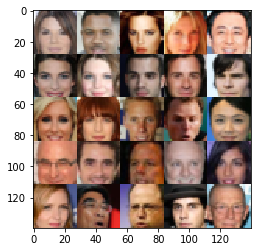

In [3]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'img_align_celeba/*.jpg'))[:show_n_images], 28, 28, 'RGB')
pyplot.imshow(helper.images_square_grid(mnist_images, 'RGB'))

## Preprocess the Data
Since the project's main focus is on building the GANs, we'll preprocess the data for you.  The values of the MNIST and CelebA dataset will be in the range of -0.5 to 0.5 of 28x28 dimensional images.  The CelebA images will be cropped to remove parts of the image that don't include a face, then resized down to 28x28.

The MNIST images are black and white images with a single [color channel](https://en.wikipedia.org/wiki/Channel_(digital_image%29) while the CelebA images have [3 color channels (RGB color channel)](https://en.wikipedia.org/wiki/Channel_(digital_image%29#RGB_Images).
## Build the Neural Network
You'll build the components necessary to build a GANs by implementing the following functions below:
- `model_inputs`
- `discriminator`
- `generator`
- `model_loss`
- `model_opt`
- `train`

### Check the Version of TensorFlow and Access to GPU
This will check to make sure you have the correct version of TensorFlow and access to a GPU

In [4]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
from distutils.version import LooseVersion
import warnings
import tensorflow as tf

# Check TensorFlow Version
assert LooseVersion(tf.__version__) >= LooseVersion('1.0'), 'Please use TensorFlow version 1.0 or newer.  You are using {}'.format(tf.__version__)
print('TensorFlow Version: {}'.format(tf.__version__))

# Check for a GPU
if not tf.test.gpu_device_name():
    warnings.warn('No GPU found. Please use a GPU to train your neural network.')
else:
    print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))

TensorFlow Version: 1.3.0
Default GPU Device: /gpu:0


### Input
Implement the `model_inputs` function to create TF Placeholders for the Neural Network. It should create the following placeholders:
- Real input images placeholder with rank 4 using `image_width`, `image_height`, and `image_channels`.
- Z input placeholder with rank 2 using `z_dim`.
- Learning rate placeholder with rank 0.

Return the placeholders in the following the tuple (tensor of real input images, tensor of z data)

In [5]:
import problem_unittests as tests

def model_inputs(image_width, image_height, image_channels, z_dim):
    """
    Create the model inputs
    :param image_width: The input image width
    :param image_height: The input image height
    :param image_channels: The number of image channels
    :param z_dim: The dimension of Z
    :return: Tuple of (tensor of real input images, tensor of z data, learning rate)
    """
    # TODO: Implement Function
    real_dim = (image_width ,image_height, image_channels)
    input_real = tf.placeholder(tf.float32, (None, *real_dim), name='input_real')
    input_z = tf.placeholder(tf.float32, (None, z_dim), name='input_z')
    learning_rate = tf.placeholder(tf.float32, None, name='learning_rate')

    return input_real, input_z, learning_rate


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_inputs(model_inputs)

ERROR:tensorflow:==================================
Object was never used (type <class 'tensorflow.python.framework.ops.Operation'>):
<tf.Operation 'assert_rank_2/Assert/Assert' type=Assert>
If you want to mark it as used call its "mark_used()" method.
It was originally created here:
['File "/usr/lib/python3.5/runpy.py", line 184, in _run_module_as_main\n    "__main__", mod_spec)', 'File "/usr/lib/python3.5/runpy.py", line 85, in _run_code\n    exec(code, run_globals)', 'File "/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py", line 16, in <module>\n    app.launch_new_instance()', 'File "/usr/local/lib/python3.5/dist-packages/traitlets/config/application.py", line 658, in launch_instance\n    app.start()', 'File "/usr/local/lib/python3.5/dist-packages/ipykernel/kernelapp.py", line 477, in start\n    ioloop.IOLoop.instance().start()', 'File "/usr/local/lib/python3.5/dist-packages/zmq/eventloop/ioloop.py", line 177, in start\n    super(ZMQIOLoop, self).start()', 'File "/usr/lo

### Discriminator
Implement `discriminator` to create a discriminator neural network that discriminates on `images`.  This function should be able to reuse the variables in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "discriminator" to allow the variables to be reused.  The function should return a tuple of (tensor output of the discriminator, tensor logits of the discriminator).

In [6]:
def discriminator(images, reuse=False, alpha=0.2, training=True):
    """
    Create the discriminator network
    :param images: Tensor of input image(s)
    :param reuse: Boolean if the weights should be reused
    :return: Tuple of (tensor output of the discriminator, tensor logits of the discriminator)
    """
    # TODO: Implement Function
    with tf.variable_scope('discriminator', reuse=reuse):
        # Input layer is 28x28x3
        x = tf.layers.conv2d(images, 64, 5, strides=(2, 2), padding='same')
        # Leaky ReLU
        x = tf.maximum(x * alpha, x)
        # Now 14x14x64
        
        x = tf.layers.conv2d(x, 128, 5, strides=(2, 2), padding='same')
        x = tf.layers.batch_normalization(x, training=training)
        x = tf.maximum(x * alpha, x)
        # Now 7x7x128
        
        x = tf.layers.conv2d(x, 256, 5, strides=(2, 2), padding='same')
        x = tf.layers.batch_normalization(x, training=training)
        x = tf.maximum(x * alpha, x)
        # Now 4x4x256
        
        # Flatten to 1D tensor
        x = tf.reshape(x, (-1, 4 * 4 * 256))
        # Now 4x4x256
        logits = tf.layers.dense(x, 1)
        output = tf.nn.sigmoid(logits)

        return output, logits


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_discriminator(discriminator, tf)

Tests Passed


### Generator
Implement `generator` to generate an image using `z`. This function should be able to reuse the variables in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "generator" to allow the variables to be reused. The function should return the generated 28 x 28 x `out_channel_dim` images.

In [7]:
def generator(z, out_channel_dim, is_train=True):
    """
    Create the generator network
    :param z: Input z
    :param out_channel_dim: The number of channels in the output image
    :param is_train: Boolean if generator is being used for training
    :return: The tensor output of the generator
    """
    # TODO: Implement Function
    alpha = 0.2
    
    with tf.variable_scope('generator', reuse= not is_train):
        x = tf.layers.dense(z, 7 * 7 * 1024)
        # Reshape tensor with -1 to flaten into a 1d
        x = tf.reshape(x, (-1, 7, 7, 256))
        # Batch Norm
        x = tf.layers.batch_normalization(x, training=is_train)
        # Leaky ReLU
        x = tf.maximum(x * alpha, x)
        # now 7x7x256
        
        x = tf.layers.conv2d_transpose(x, 256, 5, strides=(2, 2), padding='same')
        x = tf.layers.batch_normalization(x, training=is_train)
        x = tf.maximum(x * alpha, x)
        # now 14x14x256
        
        x = tf.layers.conv2d_transpose(x, 128, 5, strides=(2, 2), padding='same')
        x = tf.layers.batch_normalization(x, training=is_train)
        x = tf.maximum(x * alpha, x)
        # now 28x28x128
        
        x = tf.layers.conv2d_transpose(x, 64, 5, strides=(1, 1), padding='same')
        x = tf.layers.batch_normalization(x, training=is_train)
        x = tf.maximum(x * alpha, x)
        # now 28x28x64
        
        logits = tf.layers.conv2d_transpose(x, out_channel_dim, 5, strides=(1, 1), padding='same')
        output = tf.tanh(logits)
        # now 28x28x3
        
        return output


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_generator(generator, tf)

Tests Passed


### Loss
Implement `model_loss` to build the GANs for training and calculate the loss.  The function should return a tuple of (discriminator loss, generator loss).  Use the following functions you implemented:
- `discriminator(images, reuse=False)`
- `generator(z, out_channel_dim, is_train=True)`

In [8]:
def model_loss(input_real, input_z, out_channel_dim):
    """
    Get the loss for the discriminator and generator
    :param input_real: Images from the real dataset
    :param input_z: Z input
    :param out_channel_dim: The number of channels in the output image
    :return: A tuple of (discriminator loss, generator loss)
    """
    # TODO: Implement Function
    
    alpha=0.2
    
    g_model = generator(input_z, out_channel_dim)
    d_model_real, d_logits_real = discriminator(input_real, alpha=alpha)
    d_model_fake, d_logits_fake = discriminator(g_model, reuse=True, alpha=alpha)

    d_loss_real = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_real, labels=tf.ones_like(d_model_real)))
    d_loss_fake = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, labels=tf.zeros_like(d_model_fake)))
    g_loss = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, labels=tf.ones_like(d_model_fake)))

    d_loss = d_loss_real + d_loss_fake
    
    return d_loss, g_loss


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_loss(model_loss)

Tests Passed


### Optimization
Implement `model_opt` to create the optimization operations for the GANs. Use [`tf.trainable_variables`](https://www.tensorflow.org/api_docs/python/tf/trainable_variables) to get all the trainable variables.  Filter the variables with names that are in the discriminator and generator scope names.  The function should return a tuple of (discriminator training operation, generator training operation).

In [9]:
def model_opt(d_loss, g_loss, learning_rate, beta1):
    """
    Get optimization operations
    :param d_loss: Discriminator loss Tensor
    :param g_loss: Generator loss Tensor
    :param learning_rate: Learning Rate Placeholder
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :return: A tuple of (discriminator training operation, generator training operation)
    """
    # TODO: Implement Function
    # Get weights and bias to update
    t_vars = tf.trainable_variables()
    d_vars = [var for var in t_vars if var.name.startswith('discriminator')]
    g_vars = [var for var in t_vars if var.name.startswith('generator')]

    # Optimize
    with tf.control_dependencies(tf.get_collection(tf.GraphKeys.UPDATE_OPS)):
        d_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(d_loss, var_list=d_vars)
        g_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(g_loss, var_list=g_vars)
    
    return d_train_opt, g_train_opt


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_opt(model_opt, tf)

Tests Passed


## Neural Network Training
### Show Output
Use this function to show the current output of the generator during training. It will help you determine how well the GANs is training.

In [10]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import numpy as np

def show_generator_output(sess, n_images, input_z, out_channel_dim, image_mode):
    """
    Show example output for the generator
    :param sess: TensorFlow session
    :param n_images: Number of Images to display
    :param input_z: Input Z Tensor
    :param out_channel_dim: The number of channels in the output image
    :param image_mode: The mode to use for images ("RGB" or "L")
    """
    cmap = None if image_mode == 'RGB' else 'gray'
    z_dim = input_z.get_shape().as_list()[-1]
    example_z = np.random.uniform(-1, 1, size=[n_images, z_dim])

    samples = sess.run(
        generator(input_z, out_channel_dim, False),
        feed_dict={input_z: example_z})

    images_grid = helper.images_square_grid(samples, image_mode)
    pyplot.imshow(images_grid, cmap=cmap)
    pyplot.show()

### Train
Implement `train` to build and train the GANs.  Use the following functions you implemented:
- `model_inputs(image_width, image_height, image_channels, z_dim)`
- `model_loss(input_real, input_z, out_channel_dim)`
- `model_opt(d_loss, g_loss, learning_rate, beta1)`

Use the `show_generator_output` to show `generator` output while you train. Running `show_generator_output` for every batch will drastically increase training time and increase the size of the notebook.  It's recommended to print the `generator` output every 100 batches.

In [11]:
def train(epoch_count, batch_size, z_dim, learning_rate, beta1, get_batches, data_shape, data_image_mode):
    """
    Train the GAN
    :param epoch_count: Number of epochs
    :param batch_size: Batch Size
    :param z_dim: Z dimension
    :param learning_rate: Learning Rate
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :param get_batches: Function to get batches
    :param data_shape: Shape of the data
    :param data_image_mode: The image mode to use for images ("RGB" or "L")
    """
    
    # TODO: Build Model    
    # Reset number of steps
    samples, losses = [], []
    steps = 0
    
    # Print training data
    print_every = 10
    show_every = 100
    
    
    # Pass dim 3 or 1 depending if images have color or not
    if (data_image_mode == 'RGB'):
        out_channel_dim=3
    else:
        out_channel_dim=1
    
    
    # Add placeholder to indicate whether or not we're training the model
    is_training = tf.placeholder(tf.bool)
    
    input_real, input_z, lr = model_inputs(data_shape[1], data_shape[2], data_shape[3], z_dim)
    lr = learning_rate
    d_loss, g_loss = model_loss(input_real, input_z, out_channel_dim)
    d_opt, g_opt = model_opt(d_loss, g_loss, learning_rate, beta1)
    
 
    # Train and test the network
    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        for e in range(epoch_count):
            for batch_images in get_batches(batch_size):
                steps += 1
                
                # The values of the MNIST and CelebA dataset will be in the range of -0.5 to 0.5 of 28x28 
                # dimensional images fot fit our random uniform we multiply by 1.
                batch_images = batch_images * 2
                
                # Sample random noise for G
                batch_z = np.random.uniform(-1, 1, size=(batch_size, z_dim))

                # Run optimizers
                _ = sess.run(d_opt, feed_dict={input_real: batch_images, input_z: batch_z})
                _ = sess.run(g_opt, feed_dict={input_z: batch_z, input_real: batch_images})

                if steps % print_every == 0:
                    # At the end of each epoch, get the losses and print them out
                    train_loss_d = d_loss.eval({input_z: batch_z, input_real: batch_images})
                    train_loss_g = g_loss.eval({input_z: batch_z})

                    print("Epoch {}/{}...".format(e+1, epochs),
                          "Discriminator Loss: {:.4f}...".format(train_loss_d),
                          "Generator Loss: {:.4f}".format(train_loss_g))
                    # Save losses to view after training
                    losses.append((train_loss_d, train_loss_g))

                if steps % show_every == 0:
                    gen_samples = sess.run(
                                   generator(input_z, out_channel_dim, is_train=False),
                                   feed_dict={input_z: batch_z})
                    samples.append(gen_samples)
                    show_generator_output(sess, 10, input_z, data_shape[3], data_image_mode)


        show_generator_output(sess, 10, input_z, data_shape[3], data_image_mode)
        return losses, samples
                
                

### MNIST
Test your GANs architecture on MNIST.  After 2 epochs, the GANs should be able to generate images that look like handwritten digits.  Make sure the loss of the generator is lower than the loss of the discriminator or close to 0.

Epoch 1/2... Discriminator Loss: 0.3596... Generator Loss: 2.1468
Epoch 1/2... Discriminator Loss: 1.1680... Generator Loss: 1.5975
Epoch 1/2... Discriminator Loss: 0.2794... Generator Loss: 2.1175
Epoch 1/2... Discriminator Loss: 1.8443... Generator Loss: 0.3283
Epoch 1/2... Discriminator Loss: 0.5503... Generator Loss: 1.3117
Epoch 1/2... Discriminator Loss: 3.0108... Generator Loss: 0.2140
Epoch 1/2... Discriminator Loss: 1.2793... Generator Loss: 2.1358
Epoch 1/2... Discriminator Loss: 0.9381... Generator Loss: 2.2820
Epoch 1/2... Discriminator Loss: 0.8961... Generator Loss: 2.8417
Epoch 1/2... Discriminator Loss: 1.7433... Generator Loss: 0.3271


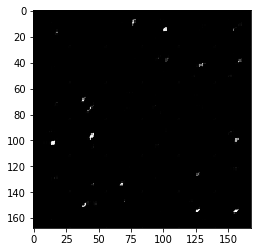

Epoch 1/2... Discriminator Loss: 0.8926... Generator Loss: 1.2772
Epoch 1/2... Discriminator Loss: 1.0635... Generator Loss: 1.0977
Epoch 1/2... Discriminator Loss: 0.5501... Generator Loss: 1.2885
Epoch 1/2... Discriminator Loss: 0.7099... Generator Loss: 2.5931
Epoch 1/2... Discriminator Loss: 0.9431... Generator Loss: 1.0223
Epoch 1/2... Discriminator Loss: 1.6105... Generator Loss: 0.3868
Epoch 1/2... Discriminator Loss: 0.7757... Generator Loss: 1.6987
Epoch 1/2... Discriminator Loss: 1.5839... Generator Loss: 0.4860
Epoch 1/2... Discriminator Loss: 0.9767... Generator Loss: 2.0973
Epoch 1/2... Discriminator Loss: 0.6546... Generator Loss: 1.2790


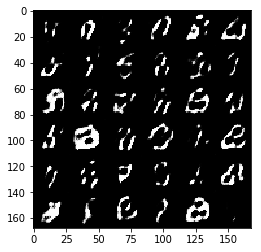

Epoch 1/2... Discriminator Loss: 0.9939... Generator Loss: 0.7238
Epoch 1/2... Discriminator Loss: 1.5632... Generator Loss: 0.4884
Epoch 1/2... Discriminator Loss: 0.9634... Generator Loss: 0.8656
Epoch 1/2... Discriminator Loss: 0.6285... Generator Loss: 1.4397
Epoch 1/2... Discriminator Loss: 0.4770... Generator Loss: 1.6915
Epoch 1/2... Discriminator Loss: 0.5102... Generator Loss: 2.2479
Epoch 1/2... Discriminator Loss: 0.7317... Generator Loss: 1.5262
Epoch 1/2... Discriminator Loss: 1.0030... Generator Loss: 0.7763
Epoch 1/2... Discriminator Loss: 2.8519... Generator Loss: 4.3918
Epoch 1/2... Discriminator Loss: 1.3088... Generator Loss: 1.2504


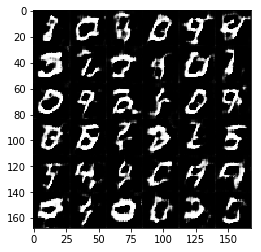

Epoch 1/2... Discriminator Loss: 1.0868... Generator Loss: 1.3254
Epoch 1/2... Discriminator Loss: 1.5816... Generator Loss: 0.4435
Epoch 1/2... Discriminator Loss: 1.0266... Generator Loss: 0.8786
Epoch 1/2... Discriminator Loss: 1.1020... Generator Loss: 0.8757
Epoch 1/2... Discriminator Loss: 1.1417... Generator Loss: 1.0389
Epoch 1/2... Discriminator Loss: 1.1754... Generator Loss: 0.6773
Epoch 1/2... Discriminator Loss: 0.9007... Generator Loss: 1.5960
Epoch 1/2... Discriminator Loss: 0.8411... Generator Loss: 1.2893
Epoch 1/2... Discriminator Loss: 1.3566... Generator Loss: 0.7235
Epoch 1/2... Discriminator Loss: 1.4991... Generator Loss: 0.4155


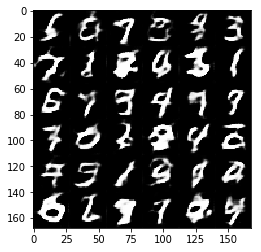

Epoch 1/2... Discriminator Loss: 0.9899... Generator Loss: 1.1959
Epoch 1/2... Discriminator Loss: 1.2316... Generator Loss: 0.6559
Epoch 1/2... Discriminator Loss: 1.2202... Generator Loss: 0.5545
Epoch 1/2... Discriminator Loss: 1.5411... Generator Loss: 1.1749
Epoch 1/2... Discriminator Loss: 1.3460... Generator Loss: 1.6301
Epoch 1/2... Discriminator Loss: 1.2749... Generator Loss: 0.5158
Epoch 1/2... Discriminator Loss: 0.9815... Generator Loss: 1.1776
Epoch 1/2... Discriminator Loss: 1.1867... Generator Loss: 1.0039
Epoch 1/2... Discriminator Loss: 1.0004... Generator Loss: 1.0037
Epoch 1/2... Discriminator Loss: 1.0971... Generator Loss: 0.7838


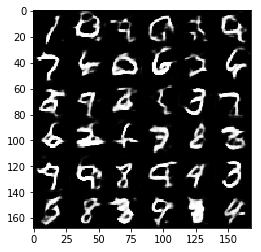

Epoch 1/2... Discriminator Loss: 1.0557... Generator Loss: 1.4514
Epoch 1/2... Discriminator Loss: 1.4502... Generator Loss: 0.4264
Epoch 1/2... Discriminator Loss: 1.0819... Generator Loss: 1.0901
Epoch 1/2... Discriminator Loss: 0.9233... Generator Loss: 0.9492
Epoch 1/2... Discriminator Loss: 0.9613... Generator Loss: 1.3537
Epoch 1/2... Discriminator Loss: 2.9029... Generator Loss: 0.1085
Epoch 1/2... Discriminator Loss: 1.1704... Generator Loss: 0.8089
Epoch 1/2... Discriminator Loss: 1.1917... Generator Loss: 0.7994
Epoch 1/2... Discriminator Loss: 1.1284... Generator Loss: 1.0160
Epoch 1/2... Discriminator Loss: 1.2460... Generator Loss: 1.0092


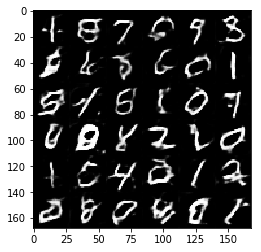

Epoch 1/2... Discriminator Loss: 1.1670... Generator Loss: 1.6777
Epoch 1/2... Discriminator Loss: 1.0165... Generator Loss: 0.8470
Epoch 1/2... Discriminator Loss: 1.2037... Generator Loss: 1.5067
Epoch 1/2... Discriminator Loss: 1.0292... Generator Loss: 1.0557
Epoch 1/2... Discriminator Loss: 1.3482... Generator Loss: 1.4833
Epoch 1/2... Discriminator Loss: 1.1326... Generator Loss: 1.3236
Epoch 1/2... Discriminator Loss: 1.1150... Generator Loss: 0.7401
Epoch 1/2... Discriminator Loss: 1.0797... Generator Loss: 0.7845
Epoch 1/2... Discriminator Loss: 1.3011... Generator Loss: 0.7358
Epoch 1/2... Discriminator Loss: 1.1276... Generator Loss: 1.0834


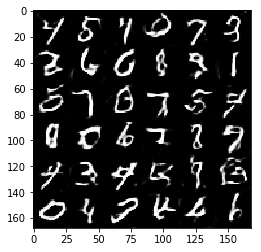

Epoch 1/2... Discriminator Loss: 1.2020... Generator Loss: 0.7882
Epoch 1/2... Discriminator Loss: 1.5070... Generator Loss: 0.4361
Epoch 1/2... Discriminator Loss: 1.0937... Generator Loss: 0.7631
Epoch 1/2... Discriminator Loss: 1.3756... Generator Loss: 0.4746
Epoch 1/2... Discriminator Loss: 1.3774... Generator Loss: 0.5720
Epoch 1/2... Discriminator Loss: 1.2622... Generator Loss: 0.8938
Epoch 1/2... Discriminator Loss: 1.1706... Generator Loss: 1.1581
Epoch 1/2... Discriminator Loss: 1.3364... Generator Loss: 0.5912
Epoch 1/2... Discriminator Loss: 1.3940... Generator Loss: 0.9343
Epoch 1/2... Discriminator Loss: 1.3239... Generator Loss: 0.5845


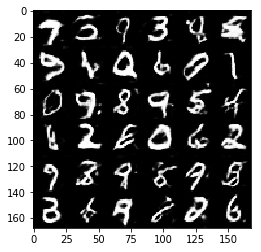

Epoch 1/2... Discriminator Loss: 1.2148... Generator Loss: 0.9842
Epoch 1/2... Discriminator Loss: 1.0782... Generator Loss: 0.9169
Epoch 1/2... Discriminator Loss: 1.5072... Generator Loss: 1.4722
Epoch 1/2... Discriminator Loss: 1.4566... Generator Loss: 0.4900
Epoch 1/2... Discriminator Loss: 1.2493... Generator Loss: 1.3852
Epoch 1/2... Discriminator Loss: 1.1215... Generator Loss: 0.8272
Epoch 1/2... Discriminator Loss: 1.2152... Generator Loss: 1.1857
Epoch 1/2... Discriminator Loss: 1.2110... Generator Loss: 0.7074
Epoch 1/2... Discriminator Loss: 1.1783... Generator Loss: 0.9096
Epoch 1/2... Discriminator Loss: 1.3716... Generator Loss: 1.5116


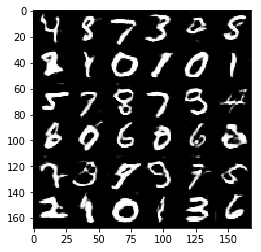

Epoch 1/2... Discriminator Loss: 1.2288... Generator Loss: 0.6937
Epoch 1/2... Discriminator Loss: 1.2835... Generator Loss: 0.7048
Epoch 1/2... Discriminator Loss: 1.2536... Generator Loss: 1.0622
Epoch 2/2... Discriminator Loss: 1.2294... Generator Loss: 0.5520
Epoch 2/2... Discriminator Loss: 1.2511... Generator Loss: 0.6177
Epoch 2/2... Discriminator Loss: 1.3221... Generator Loss: 0.5363
Epoch 2/2... Discriminator Loss: 1.1234... Generator Loss: 1.0067
Epoch 2/2... Discriminator Loss: 1.0337... Generator Loss: 0.8760
Epoch 2/2... Discriminator Loss: 1.1231... Generator Loss: 0.7526
Epoch 2/2... Discriminator Loss: 1.2137... Generator Loss: 0.8123


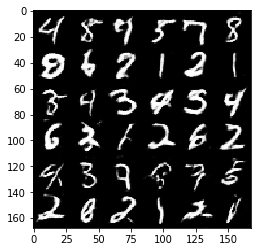

Epoch 2/2... Discriminator Loss: 1.3440... Generator Loss: 1.4515
Epoch 2/2... Discriminator Loss: 1.3543... Generator Loss: 0.5687
Epoch 2/2... Discriminator Loss: 1.1627... Generator Loss: 1.0216
Epoch 2/2... Discriminator Loss: 1.1913... Generator Loss: 0.7135
Epoch 2/2... Discriminator Loss: 1.2136... Generator Loss: 0.7337
Epoch 2/2... Discriminator Loss: 1.3819... Generator Loss: 0.4974
Epoch 2/2... Discriminator Loss: 1.2223... Generator Loss: 0.5254
Epoch 2/2... Discriminator Loss: 1.2009... Generator Loss: 0.7120
Epoch 2/2... Discriminator Loss: 1.1639... Generator Loss: 0.5970
Epoch 2/2... Discriminator Loss: 1.3042... Generator Loss: 0.7423


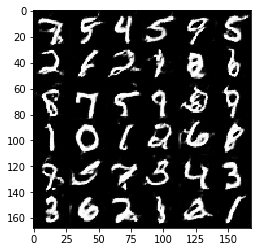

Epoch 2/2... Discriminator Loss: 1.1783... Generator Loss: 1.1246
Epoch 2/2... Discriminator Loss: 1.0794... Generator Loss: 0.9363
Epoch 2/2... Discriminator Loss: 1.2930... Generator Loss: 0.7525
Epoch 2/2... Discriminator Loss: 1.1822... Generator Loss: 0.9171
Epoch 2/2... Discriminator Loss: 1.2954... Generator Loss: 0.5820
Epoch 2/2... Discriminator Loss: 1.0973... Generator Loss: 0.9142
Epoch 2/2... Discriminator Loss: 1.2126... Generator Loss: 0.8487
Epoch 2/2... Discriminator Loss: 1.2625... Generator Loss: 0.6113
Epoch 2/2... Discriminator Loss: 1.2584... Generator Loss: 0.8817
Epoch 2/2... Discriminator Loss: 1.6117... Generator Loss: 1.7483


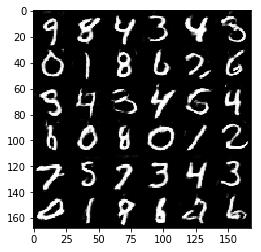

Epoch 2/2... Discriminator Loss: 1.2952... Generator Loss: 0.8026
Epoch 2/2... Discriminator Loss: 1.1441... Generator Loss: 0.8382
Epoch 2/2... Discriminator Loss: 1.3474... Generator Loss: 1.4395
Epoch 2/2... Discriminator Loss: 1.1169... Generator Loss: 0.8292
Epoch 2/2... Discriminator Loss: 1.3679... Generator Loss: 0.5387
Epoch 2/2... Discriminator Loss: 1.3181... Generator Loss: 0.9877
Epoch 2/2... Discriminator Loss: 1.3840... Generator Loss: 0.6212
Epoch 2/2... Discriminator Loss: 1.0208... Generator Loss: 0.9394
Epoch 2/2... Discriminator Loss: 1.2472... Generator Loss: 0.9017
Epoch 2/2... Discriminator Loss: 1.2914... Generator Loss: 0.9230


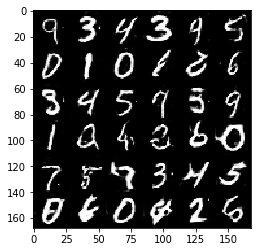

Epoch 2/2... Discriminator Loss: 1.0807... Generator Loss: 0.9103
Epoch 2/2... Discriminator Loss: 1.1385... Generator Loss: 0.8037
Epoch 2/2... Discriminator Loss: 1.2697... Generator Loss: 0.5285
Epoch 2/2... Discriminator Loss: 1.3139... Generator Loss: 0.5665
Epoch 2/2... Discriminator Loss: 1.1102... Generator Loss: 0.9651
Epoch 2/2... Discriminator Loss: 1.2815... Generator Loss: 0.5777
Epoch 2/2... Discriminator Loss: 1.2688... Generator Loss: 0.6687
Epoch 2/2... Discriminator Loss: 1.2047... Generator Loss: 0.7460
Epoch 2/2... Discriminator Loss: 1.2267... Generator Loss: 1.0821
Epoch 2/2... Discriminator Loss: 1.2339... Generator Loss: 0.9418


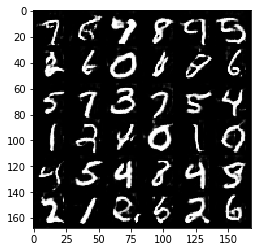

Epoch 2/2... Discriminator Loss: 1.2836... Generator Loss: 0.6303
Epoch 2/2... Discriminator Loss: 1.2620... Generator Loss: 0.8640
Epoch 2/2... Discriminator Loss: 1.2223... Generator Loss: 0.5442
Epoch 2/2... Discriminator Loss: 1.2738... Generator Loss: 0.5971
Epoch 2/2... Discriminator Loss: 1.2449... Generator Loss: 0.9333
Epoch 2/2... Discriminator Loss: 1.1905... Generator Loss: 0.8559
Epoch 2/2... Discriminator Loss: 1.2824... Generator Loss: 0.7537
Epoch 2/2... Discriminator Loss: 1.1988... Generator Loss: 0.8524
Epoch 2/2... Discriminator Loss: 1.2265... Generator Loss: 0.6758
Epoch 2/2... Discriminator Loss: 1.2541... Generator Loss: 0.9015


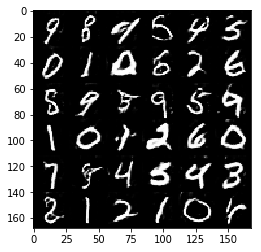

Epoch 2/2... Discriminator Loss: 1.2593... Generator Loss: 1.2746
Epoch 2/2... Discriminator Loss: 1.8126... Generator Loss: 0.2705
Epoch 2/2... Discriminator Loss: 1.2544... Generator Loss: 0.7012
Epoch 2/2... Discriminator Loss: 1.2793... Generator Loss: 1.0089
Epoch 2/2... Discriminator Loss: 1.2508... Generator Loss: 0.5841
Epoch 2/2... Discriminator Loss: 1.1970... Generator Loss: 0.6809
Epoch 2/2... Discriminator Loss: 1.3198... Generator Loss: 0.7720
Epoch 2/2... Discriminator Loss: 1.0425... Generator Loss: 0.8513
Epoch 2/2... Discriminator Loss: 0.9893... Generator Loss: 0.9952
Epoch 2/2... Discriminator Loss: 1.2620... Generator Loss: 0.8212


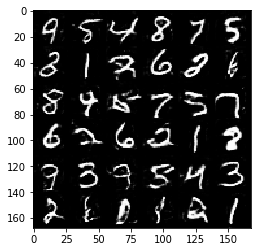

Epoch 2/2... Discriminator Loss: 1.4791... Generator Loss: 0.4109
Epoch 2/2... Discriminator Loss: 1.3182... Generator Loss: 0.5799
Epoch 2/2... Discriminator Loss: 1.2463... Generator Loss: 0.8394
Epoch 2/2... Discriminator Loss: 1.2802... Generator Loss: 1.3364
Epoch 2/2... Discriminator Loss: 1.2129... Generator Loss: 0.8970
Epoch 2/2... Discriminator Loss: 1.2063... Generator Loss: 0.6604
Epoch 2/2... Discriminator Loss: 1.4410... Generator Loss: 1.0434
Epoch 2/2... Discriminator Loss: 1.0586... Generator Loss: 0.7020
Epoch 2/2... Discriminator Loss: 1.3445... Generator Loss: 0.6689
Epoch 2/2... Discriminator Loss: 1.0766... Generator Loss: 0.6942


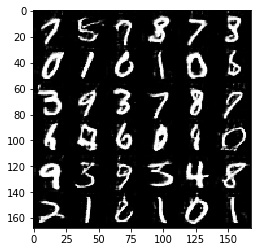

Epoch 2/2... Discriminator Loss: 1.6649... Generator Loss: 1.7340
Epoch 2/2... Discriminator Loss: 1.2668... Generator Loss: 0.7073
Epoch 2/2... Discriminator Loss: 1.1013... Generator Loss: 0.7502
Epoch 2/2... Discriminator Loss: 1.2010... Generator Loss: 0.6386
Epoch 2/2... Discriminator Loss: 1.1903... Generator Loss: 1.0664
Epoch 2/2... Discriminator Loss: 1.1310... Generator Loss: 1.0190
Epoch 2/2... Discriminator Loss: 1.1403... Generator Loss: 0.5615
Epoch 2/2... Discriminator Loss: 1.0622... Generator Loss: 1.0597
Epoch 2/2... Discriminator Loss: 1.3168... Generator Loss: 0.6078
Epoch 2/2... Discriminator Loss: 1.7033... Generator Loss: 0.3505


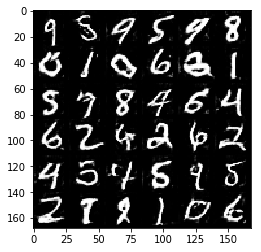

Epoch 2/2... Discriminator Loss: 1.2588... Generator Loss: 0.8803
Epoch 2/2... Discriminator Loss: 1.4525... Generator Loss: 0.5002
Epoch 2/2... Discriminator Loss: 1.4520... Generator Loss: 0.4301
Epoch 2/2... Discriminator Loss: 1.6608... Generator Loss: 1.2678
Epoch 2/2... Discriminator Loss: 1.4512... Generator Loss: 0.5068
Epoch 2/2... Discriminator Loss: 1.4991... Generator Loss: 1.6653
Epoch 2/2... Discriminator Loss: 1.4019... Generator Loss: 0.4869


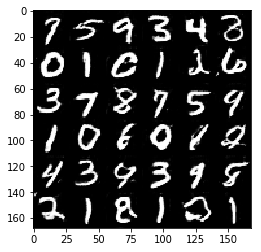

In [12]:
batch_size = 64
z_dim = 100
learning_rate = 0.002
beta1 = 0.6

tf.reset_default_graph()

"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 2

mnist_dataset = helper.Dataset('mnist', glob(os.path.join(data_dir, 'mnist/*.jpg')))
with tf.Graph().as_default():
    losses, samples = train(epochs, batch_size, z_dim, learning_rate, beta1, mnist_dataset.get_batches,
          mnist_dataset.shape, mnist_dataset.image_mode)

In [13]:
import matplotlib.pyplot as plt
import numpy as np
from scipy.io import loadmat

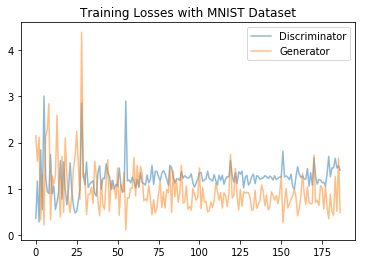

In [ ]:
fig, ax = plt.subplots()
losses = np.array(losses)
plt.plot(losses.T[0], label='Discriminator', alpha=0.5)
plt.plot(losses.T[1], label='Generator', alpha=0.5)
plt.title("Training Losses with MNIST Dataset")
plt.legend()

### CelebA
Run your GANs on CelebA.  It will take around 20 minutes on the average GPU to run one epoch.  You can run the whole epoch or stop when it starts to generate realistic faces.

Epoch 1/1... Discriminator Loss: 1.1408... Generator Loss: 0.6913
Epoch 1/1... Discriminator Loss: 1.5360... Generator Loss: 3.2149
Epoch 1/1... Discriminator Loss: 1.4731... Generator Loss: 1.3068
Epoch 1/1... Discriminator Loss: 1.3550... Generator Loss: 0.9882
Epoch 1/1... Discriminator Loss: 1.5421... Generator Loss: 0.3908
Epoch 1/1... Discriminator Loss: 1.9684... Generator Loss: 0.2293
Epoch 1/1... Discriminator Loss: 1.6243... Generator Loss: 0.3544
Epoch 1/1... Discriminator Loss: 2.2081... Generator Loss: 0.1672
Epoch 1/1... Discriminator Loss: 1.9270... Generator Loss: 0.2499
Epoch 1/1... Discriminator Loss: 1.3921... Generator Loss: 0.4174


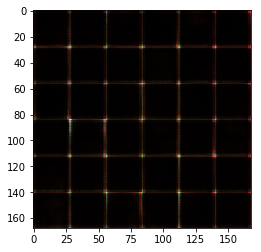

Epoch 1/1... Discriminator Loss: 1.9922... Generator Loss: 0.2407
Epoch 1/1... Discriminator Loss: 2.0096... Generator Loss: 0.2149
Epoch 1/1... Discriminator Loss: 1.3021... Generator Loss: 0.5460
Epoch 1/1... Discriminator Loss: 2.0258... Generator Loss: 0.1903
Epoch 1/1... Discriminator Loss: 1.8183... Generator Loss: 0.2619
Epoch 1/1... Discriminator Loss: 2.5954... Generator Loss: 0.1086
Epoch 1/1... Discriminator Loss: 1.9183... Generator Loss: 0.2208
Epoch 1/1... Discriminator Loss: 0.8167... Generator Loss: 0.9589
Epoch 1/1... Discriminator Loss: 1.0285... Generator Loss: 1.6501
Epoch 1/1... Discriminator Loss: 2.1334... Generator Loss: 0.1561


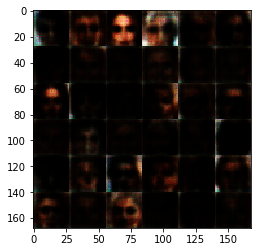

Epoch 1/1... Discriminator Loss: 1.8561... Generator Loss: 0.2236
Epoch 1/1... Discriminator Loss: 2.1816... Generator Loss: 0.1514
Epoch 1/1... Discriminator Loss: 1.8015... Generator Loss: 0.2400
Epoch 1/1... Discriminator Loss: 1.7536... Generator Loss: 0.2718
Epoch 1/1... Discriminator Loss: 1.4826... Generator Loss: 0.3910
Epoch 1/1... Discriminator Loss: 0.6520... Generator Loss: 1.4731
Epoch 1/1... Discriminator Loss: 1.4178... Generator Loss: 0.5632
Epoch 1/1... Discriminator Loss: 1.5819... Generator Loss: 0.3391
Epoch 1/1... Discriminator Loss: 0.9675... Generator Loss: 0.9344
Epoch 1/1... Discriminator Loss: 1.6893... Generator Loss: 0.2800


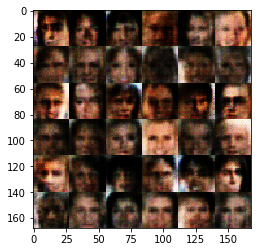

Epoch 1/1... Discriminator Loss: 1.3445... Generator Loss: 0.4290
Epoch 1/1... Discriminator Loss: 1.7403... Generator Loss: 0.2603
Epoch 1/1... Discriminator Loss: 1.8482... Generator Loss: 0.2524
Epoch 1/1... Discriminator Loss: 1.2576... Generator Loss: 0.6279
Epoch 1/1... Discriminator Loss: 1.4729... Generator Loss: 0.4030
Epoch 1/1... Discriminator Loss: 1.3831... Generator Loss: 0.4103
Epoch 1/1... Discriminator Loss: 2.2001... Generator Loss: 0.1595
Epoch 1/1... Discriminator Loss: 1.7670... Generator Loss: 0.2591
Epoch 1/1... Discriminator Loss: 1.2352... Generator Loss: 0.8267
Epoch 1/1... Discriminator Loss: 1.7017... Generator Loss: 0.2714


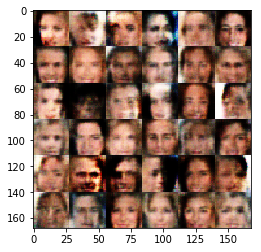

Epoch 1/1... Discriminator Loss: 1.3975... Generator Loss: 0.5297
Epoch 1/1... Discriminator Loss: 1.3000... Generator Loss: 0.5412
Epoch 1/1... Discriminator Loss: 1.8485... Generator Loss: 0.2329
Epoch 1/1... Discriminator Loss: 1.4034... Generator Loss: 0.4376
Epoch 1/1... Discriminator Loss: 1.0680... Generator Loss: 1.1531
Epoch 1/1... Discriminator Loss: 2.3627... Generator Loss: 1.2306
Epoch 1/1... Discriminator Loss: 1.2572... Generator Loss: 0.7266
Epoch 1/1... Discriminator Loss: 1.1204... Generator Loss: 0.6238
Epoch 1/1... Discriminator Loss: 1.5042... Generator Loss: 0.4469
Epoch 1/1... Discriminator Loss: 1.1696... Generator Loss: 0.9153


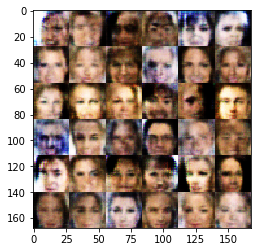

Epoch 1/1... Discriminator Loss: 1.6589... Generator Loss: 0.2657
Epoch 1/1... Discriminator Loss: 1.5703... Generator Loss: 0.6334
Epoch 1/1... Discriminator Loss: 1.2696... Generator Loss: 0.5918
Epoch 1/1... Discriminator Loss: 1.7947... Generator Loss: 0.2454
Epoch 1/1... Discriminator Loss: 1.1216... Generator Loss: 1.1252
Epoch 1/1... Discriminator Loss: 1.5264... Generator Loss: 0.3817
Epoch 1/1... Discriminator Loss: 1.1490... Generator Loss: 0.8584
Epoch 1/1... Discriminator Loss: 1.3843... Generator Loss: 0.7573
Epoch 1/1... Discriminator Loss: 1.3010... Generator Loss: 0.7017
Epoch 1/1... Discriminator Loss: 1.1329... Generator Loss: 1.0932


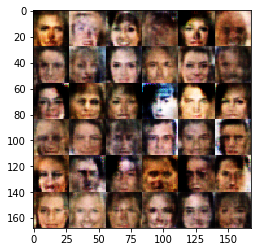

Epoch 1/1... Discriminator Loss: 1.1742... Generator Loss: 0.6616
Epoch 1/1... Discriminator Loss: 1.4952... Generator Loss: 0.7912
Epoch 1/1... Discriminator Loss: 1.4607... Generator Loss: 0.7191
Epoch 1/1... Discriminator Loss: 1.5094... Generator Loss: 0.4401
Epoch 1/1... Discriminator Loss: 1.6176... Generator Loss: 0.2915
Epoch 1/1... Discriminator Loss: 1.4433... Generator Loss: 0.4422
Epoch 1/1... Discriminator Loss: 1.6901... Generator Loss: 1.0832
Epoch 1/1... Discriminator Loss: 1.7128... Generator Loss: 0.2859
Epoch 1/1... Discriminator Loss: 1.5002... Generator Loss: 0.6195
Epoch 1/1... Discriminator Loss: 1.2715... Generator Loss: 0.7601


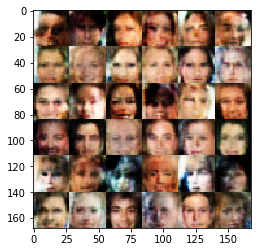

Epoch 1/1... Discriminator Loss: 1.1462... Generator Loss: 0.9328
Epoch 1/1... Discriminator Loss: 1.5839... Generator Loss: 0.9548
Epoch 1/1... Discriminator Loss: 1.3178... Generator Loss: 0.7551
Epoch 1/1... Discriminator Loss: 1.4538... Generator Loss: 0.5887
Epoch 1/1... Discriminator Loss: 1.3938... Generator Loss: 0.5317
Epoch 1/1... Discriminator Loss: 1.3630... Generator Loss: 0.5029
Epoch 1/1... Discriminator Loss: 1.6440... Generator Loss: 0.5344
Epoch 1/1... Discriminator Loss: 1.4708... Generator Loss: 0.5171
Epoch 1/1... Discriminator Loss: 1.3753... Generator Loss: 0.5608
Epoch 1/1... Discriminator Loss: 1.5476... Generator Loss: 0.7491


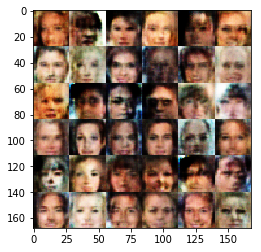

Epoch 1/1... Discriminator Loss: 1.6234... Generator Loss: 0.3049
Epoch 1/1... Discriminator Loss: 1.3973... Generator Loss: 0.4843
Epoch 1/1... Discriminator Loss: 1.5327... Generator Loss: 0.4941
Epoch 1/1... Discriminator Loss: 1.3615... Generator Loss: 0.6432
Epoch 1/1... Discriminator Loss: 1.4799... Generator Loss: 0.4110
Epoch 1/1... Discriminator Loss: 1.4630... Generator Loss: 0.6695
Epoch 1/1... Discriminator Loss: 1.3706... Generator Loss: 0.6239
Epoch 1/1... Discriminator Loss: 1.1381... Generator Loss: 0.7580
Epoch 1/1... Discriminator Loss: 1.2823... Generator Loss: 0.5023
Epoch 1/1... Discriminator Loss: 1.3734... Generator Loss: 0.7161


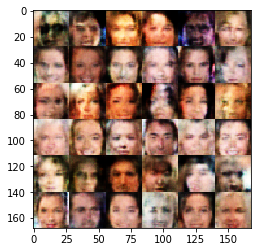

Epoch 1/1... Discriminator Loss: 1.4353... Generator Loss: 0.6566
Epoch 1/1... Discriminator Loss: 1.4565... Generator Loss: 0.5609
Epoch 1/1... Discriminator Loss: 1.3353... Generator Loss: 1.0040
Epoch 1/1... Discriminator Loss: 1.3287... Generator Loss: 0.5984
Epoch 1/1... Discriminator Loss: 1.0774... Generator Loss: 0.8602
Epoch 1/1... Discriminator Loss: 1.4560... Generator Loss: 0.6159
Epoch 1/1... Discriminator Loss: 1.4159... Generator Loss: 1.0630
Epoch 1/1... Discriminator Loss: 1.5030... Generator Loss: 0.6141
Epoch 1/1... Discriminator Loss: 1.3009... Generator Loss: 0.6013
Epoch 1/1... Discriminator Loss: 1.4189... Generator Loss: 0.6774


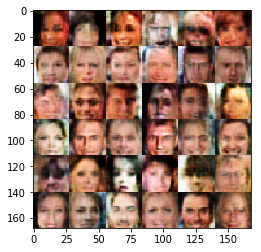

Epoch 1/1... Discriminator Loss: 1.2755... Generator Loss: 0.7955
Epoch 1/1... Discriminator Loss: 1.4186... Generator Loss: 0.5193
Epoch 1/1... Discriminator Loss: 1.2661... Generator Loss: 0.5930
Epoch 1/1... Discriminator Loss: 1.0283... Generator Loss: 1.0315
Epoch 1/1... Discriminator Loss: 1.3261... Generator Loss: 0.5710
Epoch 1/1... Discriminator Loss: 1.3220... Generator Loss: 0.5695
Epoch 1/1... Discriminator Loss: 1.2156... Generator Loss: 0.8165
Epoch 1/1... Discriminator Loss: 1.4780... Generator Loss: 0.6051
Epoch 1/1... Discriminator Loss: 1.4686... Generator Loss: 0.6368
Epoch 1/1... Discriminator Loss: 1.4535... Generator Loss: 0.5763


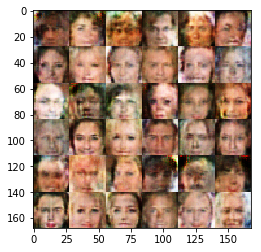

Epoch 1/1... Discriminator Loss: 1.4611... Generator Loss: 0.5661
Epoch 1/1... Discriminator Loss: 1.4585... Generator Loss: 0.6259
Epoch 1/1... Discriminator Loss: 1.4356... Generator Loss: 0.6113
Epoch 1/1... Discriminator Loss: 1.3602... Generator Loss: 0.7469
Epoch 1/1... Discriminator Loss: 1.3993... Generator Loss: 0.5681
Epoch 1/1... Discriminator Loss: 1.3681... Generator Loss: 0.6433
Epoch 1/1... Discriminator Loss: 1.6958... Generator Loss: 0.3217
Epoch 1/1... Discriminator Loss: 1.4213... Generator Loss: 0.5503
Epoch 1/1... Discriminator Loss: 1.4178... Generator Loss: 0.6581
Epoch 1/1... Discriminator Loss: 1.3839... Generator Loss: 0.7283


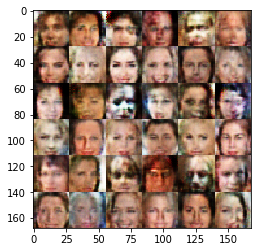

Epoch 1/1... Discriminator Loss: 1.5098... Generator Loss: 0.5335
Epoch 1/1... Discriminator Loss: 1.5209... Generator Loss: 0.4289
Epoch 1/1... Discriminator Loss: 1.3790... Generator Loss: 0.6268
Epoch 1/1... Discriminator Loss: 1.4682... Generator Loss: 0.6565
Epoch 1/1... Discriminator Loss: 1.4291... Generator Loss: 0.5132
Epoch 1/1... Discriminator Loss: 1.5690... Generator Loss: 0.3275
Epoch 1/1... Discriminator Loss: 1.3701... Generator Loss: 0.6902
Epoch 1/1... Discriminator Loss: 1.3983... Generator Loss: 0.6932
Epoch 1/1... Discriminator Loss: 1.3949... Generator Loss: 0.6325
Epoch 1/1... Discriminator Loss: 1.4601... Generator Loss: 0.5685


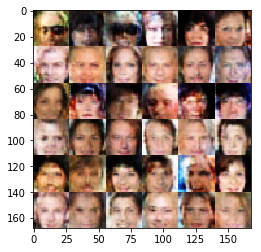

Epoch 1/1... Discriminator Loss: 1.6546... Generator Loss: 0.2851
Epoch 1/1... Discriminator Loss: 1.2266... Generator Loss: 0.5693
Epoch 1/1... Discriminator Loss: 1.3835... Generator Loss: 0.5632
Epoch 1/1... Discriminator Loss: 1.3214... Generator Loss: 0.5928
Epoch 1/1... Discriminator Loss: 1.1630... Generator Loss: 0.8419
Epoch 1/1... Discriminator Loss: 1.7669... Generator Loss: 0.2814
Epoch 1/1... Discriminator Loss: 1.4993... Generator Loss: 0.5817
Epoch 1/1... Discriminator Loss: 1.4257... Generator Loss: 0.5994
Epoch 1/1... Discriminator Loss: 1.4955... Generator Loss: 0.5359
Epoch 1/1... Discriminator Loss: 1.4504... Generator Loss: 0.6187


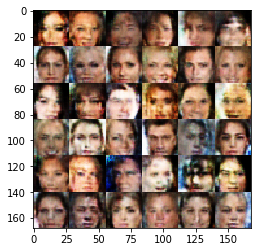

Epoch 1/1... Discriminator Loss: 1.3946... Generator Loss: 0.6402
Epoch 1/1... Discriminator Loss: 1.4175... Generator Loss: 0.5809
Epoch 1/1... Discriminator Loss: 1.0518... Generator Loss: 0.8964
Epoch 1/1... Discriminator Loss: 1.4493... Generator Loss: 0.5187
Epoch 1/1... Discriminator Loss: 1.4329... Generator Loss: 0.5669
Epoch 1/1... Discriminator Loss: 1.2752... Generator Loss: 0.6175
Epoch 1/1... Discriminator Loss: 1.3992... Generator Loss: 0.5689
Epoch 1/1... Discriminator Loss: 1.5002... Generator Loss: 0.5669
Epoch 1/1... Discriminator Loss: 1.4371... Generator Loss: 0.5713
Epoch 1/1... Discriminator Loss: 1.4381... Generator Loss: 0.5702


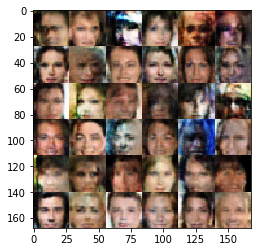

Epoch 1/1... Discriminator Loss: 1.3682... Generator Loss: 0.6791
Epoch 1/1... Discriminator Loss: 1.2897... Generator Loss: 0.6960
Epoch 1/1... Discriminator Loss: 1.1832... Generator Loss: 0.7891
Epoch 1/1... Discriminator Loss: 1.3670... Generator Loss: 0.6534
Epoch 1/1... Discriminator Loss: 1.3943... Generator Loss: 0.6462
Epoch 1/1... Discriminator Loss: 1.4037... Generator Loss: 0.5614
Epoch 1/1... Discriminator Loss: 1.1935... Generator Loss: 0.9877
Epoch 1/1... Discriminator Loss: 1.3307... Generator Loss: 0.5214
Epoch 1/1... Discriminator Loss: 1.0713... Generator Loss: 1.5464
Epoch 1/1... Discriminator Loss: 2.2963... Generator Loss: 1.5525


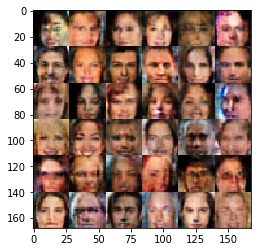

Epoch 1/1... Discriminator Loss: 1.3486... Generator Loss: 0.6643
Epoch 1/1... Discriminator Loss: 1.4138... Generator Loss: 0.5968
Epoch 1/1... Discriminator Loss: 1.4591... Generator Loss: 0.5820
Epoch 1/1... Discriminator Loss: 1.4290... Generator Loss: 0.6065
Epoch 1/1... Discriminator Loss: 1.3266... Generator Loss: 0.5818
Epoch 1/1... Discriminator Loss: 1.3990... Generator Loss: 0.8911
Epoch 1/1... Discriminator Loss: 1.3684... Generator Loss: 1.9165
Epoch 1/1... Discriminator Loss: 1.4518... Generator Loss: 0.5641
Epoch 1/1... Discriminator Loss: 1.3995... Generator Loss: 0.6152
Epoch 1/1... Discriminator Loss: 1.1369... Generator Loss: 0.7865


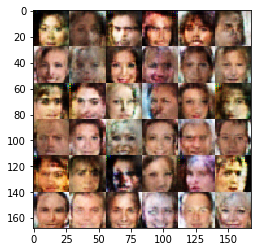

Epoch 1/1... Discriminator Loss: 1.4823... Generator Loss: 0.5792
Epoch 1/1... Discriminator Loss: 1.3259... Generator Loss: 0.5724
Epoch 1/1... Discriminator Loss: 1.4141... Generator Loss: 0.5726
Epoch 1/1... Discriminator Loss: 1.2347... Generator Loss: 0.6665
Epoch 1/1... Discriminator Loss: 1.4602... Generator Loss: 0.5777
Epoch 1/1... Discriminator Loss: 1.3747... Generator Loss: 0.6056
Epoch 1/1... Discriminator Loss: 1.4934... Generator Loss: 0.5153
Epoch 1/1... Discriminator Loss: 1.4140... Generator Loss: 0.4075
Epoch 1/1... Discriminator Loss: 1.3939... Generator Loss: 0.6324
Epoch 1/1... Discriminator Loss: 1.3516... Generator Loss: 0.7645


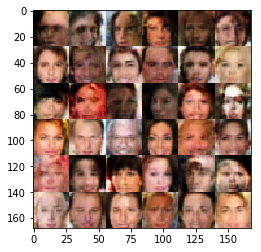

Epoch 1/1... Discriminator Loss: 1.3115... Generator Loss: 0.6202
Epoch 1/1... Discriminator Loss: 1.4053... Generator Loss: 0.5358
Epoch 1/1... Discriminator Loss: 1.3969... Generator Loss: 0.6019
Epoch 1/1... Discriminator Loss: 1.4091... Generator Loss: 0.5339
Epoch 1/1... Discriminator Loss: 0.9938... Generator Loss: 1.1929
Epoch 1/1... Discriminator Loss: 1.3613... Generator Loss: 0.4872
Epoch 1/1... Discriminator Loss: 1.2808... Generator Loss: 0.8452
Epoch 1/1... Discriminator Loss: 1.3659... Generator Loss: 0.6943
Epoch 1/1... Discriminator Loss: 1.1822... Generator Loss: 0.7312
Epoch 1/1... Discriminator Loss: 1.5102... Generator Loss: 0.3798


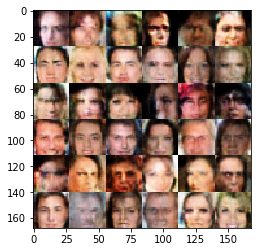

Epoch 1/1... Discriminator Loss: 1.2871... Generator Loss: 0.6520
Epoch 1/1... Discriminator Loss: 1.4355... Generator Loss: 0.4277
Epoch 1/1... Discriminator Loss: 1.4187... Generator Loss: 0.4963
Epoch 1/1... Discriminator Loss: 1.4705... Generator Loss: 0.3367
Epoch 1/1... Discriminator Loss: 1.4373... Generator Loss: 0.6110
Epoch 1/1... Discriminator Loss: 1.3881... Generator Loss: 0.6918
Epoch 1/1... Discriminator Loss: 1.6654... Generator Loss: 0.4390
Epoch 1/1... Discriminator Loss: 1.3052... Generator Loss: 0.7867
Epoch 1/1... Discriminator Loss: 1.2989... Generator Loss: 0.6410
Epoch 1/1... Discriminator Loss: 1.3943... Generator Loss: 0.4696


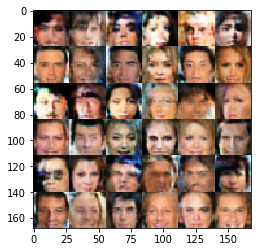

Epoch 1/1... Discriminator Loss: 1.4793... Generator Loss: 0.8665
Epoch 1/1... Discriminator Loss: 1.4632... Generator Loss: 0.5874
Epoch 1/1... Discriminator Loss: 1.3801... Generator Loss: 0.7244
Epoch 1/1... Discriminator Loss: 1.2935... Generator Loss: 0.9343
Epoch 1/1... Discriminator Loss: 1.3957... Generator Loss: 0.7819
Epoch 1/1... Discriminator Loss: 1.1240... Generator Loss: 1.1835
Epoch 1/1... Discriminator Loss: 1.3495... Generator Loss: 0.6704
Epoch 1/1... Discriminator Loss: 1.1299... Generator Loss: 0.7940
Epoch 1/1... Discriminator Loss: 1.1609... Generator Loss: 0.7546
Epoch 1/1... Discriminator Loss: 1.2338... Generator Loss: 0.7542


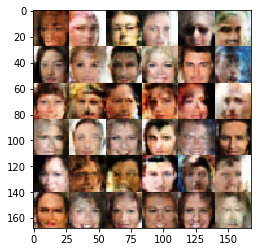

Epoch 1/1... Discriminator Loss: 1.4152... Generator Loss: 0.7920
Epoch 1/1... Discriminator Loss: 1.3968... Generator Loss: 0.5065
Epoch 1/1... Discriminator Loss: 1.3602... Generator Loss: 0.6176
Epoch 1/1... Discriminator Loss: 1.2663... Generator Loss: 0.6862
Epoch 1/1... Discriminator Loss: 1.3672... Generator Loss: 0.4726
Epoch 1/1... Discriminator Loss: 1.1585... Generator Loss: 0.6250
Epoch 1/1... Discriminator Loss: 1.4601... Generator Loss: 0.4185
Epoch 1/1... Discriminator Loss: 1.3710... Generator Loss: 0.5696
Epoch 1/1... Discriminator Loss: 1.3363... Generator Loss: 0.5966
Epoch 1/1... Discriminator Loss: 1.2194... Generator Loss: 0.8988


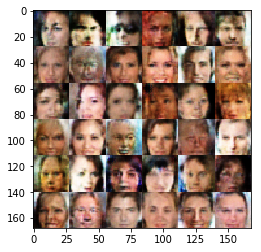

Epoch 1/1... Discriminator Loss: 1.3445... Generator Loss: 0.5428
Epoch 1/1... Discriminator Loss: 1.2082... Generator Loss: 0.8195
Epoch 1/1... Discriminator Loss: 1.0960... Generator Loss: 1.0259
Epoch 1/1... Discriminator Loss: 1.1550... Generator Loss: 1.1278
Epoch 1/1... Discriminator Loss: 1.2072... Generator Loss: 0.6848
Epoch 1/1... Discriminator Loss: 1.2615... Generator Loss: 0.7832
Epoch 1/1... Discriminator Loss: 1.0089... Generator Loss: 1.0507
Epoch 1/1... Discriminator Loss: 1.2175... Generator Loss: 0.8213
Epoch 1/1... Discriminator Loss: 1.3606... Generator Loss: 0.7511
Epoch 1/1... Discriminator Loss: 1.4669... Generator Loss: 0.4182


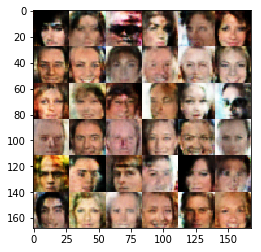

Epoch 1/1... Discriminator Loss: 1.3275... Generator Loss: 0.6305
Epoch 1/1... Discriminator Loss: 1.4094... Generator Loss: 0.6648
Epoch 1/1... Discriminator Loss: 1.2530... Generator Loss: 0.7591
Epoch 1/1... Discriminator Loss: 1.3697... Generator Loss: 0.4294
Epoch 1/1... Discriminator Loss: 1.1989... Generator Loss: 0.7217
Epoch 1/1... Discriminator Loss: 1.3565... Generator Loss: 0.4731
Epoch 1/1... Discriminator Loss: 1.3488... Generator Loss: 0.5134
Epoch 1/1... Discriminator Loss: 1.5402... Generator Loss: 0.4316
Epoch 1/1... Discriminator Loss: 1.4240... Generator Loss: 0.5887
Epoch 1/1... Discriminator Loss: 1.4849... Generator Loss: 0.4212


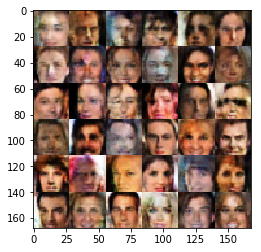

Epoch 1/1... Discriminator Loss: 1.6891... Generator Loss: 1.1513
Epoch 1/1... Discriminator Loss: 1.3143... Generator Loss: 0.6725
Epoch 1/1... Discriminator Loss: 1.3307... Generator Loss: 0.8171
Epoch 1/1... Discriminator Loss: 1.2270... Generator Loss: 0.6510
Epoch 1/1... Discriminator Loss: 1.3979... Generator Loss: 0.5456
Epoch 1/1... Discriminator Loss: 1.3046... Generator Loss: 0.6336
Epoch 1/1... Discriminator Loss: 1.3916... Generator Loss: 0.5504
Epoch 1/1... Discriminator Loss: 1.3350... Generator Loss: 0.5877
Epoch 1/1... Discriminator Loss: 1.4104... Generator Loss: 0.4676
Epoch 1/1... Discriminator Loss: 1.1773... Generator Loss: 0.8168


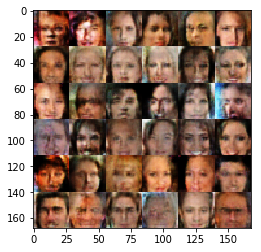

Epoch 1/1... Discriminator Loss: 1.1186... Generator Loss: 0.9578
Epoch 1/1... Discriminator Loss: 1.6788... Generator Loss: 1.1044
Epoch 1/1... Discriminator Loss: 1.2738... Generator Loss: 0.8249
Epoch 1/1... Discriminator Loss: 1.4438... Generator Loss: 0.5727
Epoch 1/1... Discriminator Loss: 1.3348... Generator Loss: 0.6144
Epoch 1/1... Discriminator Loss: 1.3598... Generator Loss: 0.6608
Epoch 1/1... Discriminator Loss: 1.5004... Generator Loss: 0.4486
Epoch 1/1... Discriminator Loss: 1.3649... Generator Loss: 0.5488
Epoch 1/1... Discriminator Loss: 1.2531... Generator Loss: 0.5893
Epoch 1/1... Discriminator Loss: 1.1905... Generator Loss: 0.5558


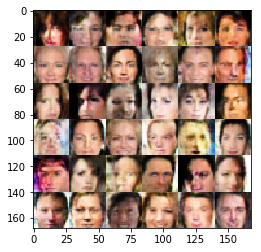

Epoch 1/1... Discriminator Loss: 1.4558... Generator Loss: 0.6778
Epoch 1/1... Discriminator Loss: 1.3431... Generator Loss: 0.6642
Epoch 1/1... Discriminator Loss: 1.3824... Generator Loss: 0.7130
Epoch 1/1... Discriminator Loss: 1.5861... Generator Loss: 1.2240
Epoch 1/1... Discriminator Loss: 1.3008... Generator Loss: 1.1710
Epoch 1/1... Discriminator Loss: 1.0983... Generator Loss: 0.8606
Epoch 1/1... Discriminator Loss: 1.3488... Generator Loss: 0.6113
Epoch 1/1... Discriminator Loss: 1.2960... Generator Loss: 0.7643
Epoch 1/1... Discriminator Loss: 1.3309... Generator Loss: 0.5613
Epoch 1/1... Discriminator Loss: 1.2986... Generator Loss: 0.5853


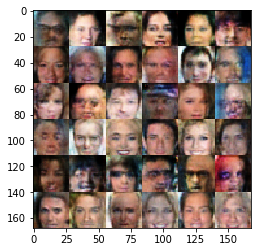

Epoch 1/1... Discriminator Loss: 1.3351... Generator Loss: 0.6981
Epoch 1/1... Discriminator Loss: 1.3120... Generator Loss: 0.8320
Epoch 1/1... Discriminator Loss: 0.9846... Generator Loss: 0.6639
Epoch 1/1... Discriminator Loss: 1.3946... Generator Loss: 0.5815
Epoch 1/1... Discriminator Loss: 1.5263... Generator Loss: 0.5483
Epoch 1/1... Discriminator Loss: 1.4675... Generator Loss: 0.5541
Epoch 1/1... Discriminator Loss: 1.4369... Generator Loss: 0.7957
Epoch 1/1... Discriminator Loss: 1.0123... Generator Loss: 0.8295
Epoch 1/1... Discriminator Loss: 1.4781... Generator Loss: 0.5412
Epoch 1/1... Discriminator Loss: 1.4607... Generator Loss: 0.4130


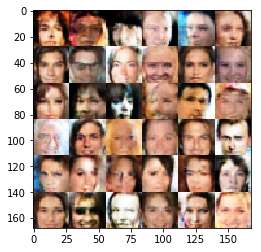

Epoch 1/1... Discriminator Loss: 1.4490... Generator Loss: 0.4926
Epoch 1/1... Discriminator Loss: 1.3535... Generator Loss: 0.4418
Epoch 1/1... Discriminator Loss: 1.0733... Generator Loss: 0.8860
Epoch 1/1... Discriminator Loss: 1.0926... Generator Loss: 0.8189
Epoch 1/1... Discriminator Loss: 1.2644... Generator Loss: 0.7409
Epoch 1/1... Discriminator Loss: 1.3639... Generator Loss: 0.8296
Epoch 1/1... Discriminator Loss: 1.2741... Generator Loss: 0.6128
Epoch 1/1... Discriminator Loss: 1.4525... Generator Loss: 0.5514
Epoch 1/1... Discriminator Loss: 1.5017... Generator Loss: 0.4437
Epoch 1/1... Discriminator Loss: 1.2521... Generator Loss: 0.6223


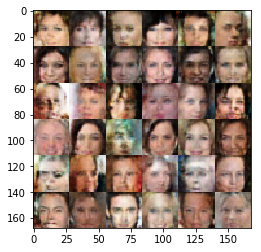

Epoch 1/1... Discriminator Loss: 1.4571... Generator Loss: 0.4697
Epoch 1/1... Discriminator Loss: 1.2026... Generator Loss: 0.6378
Epoch 1/1... Discriminator Loss: 1.4543... Generator Loss: 0.4523
Epoch 1/1... Discriminator Loss: 1.3264... Generator Loss: 0.7300
Epoch 1/1... Discriminator Loss: 1.3863... Generator Loss: 0.5302
Epoch 1/1... Discriminator Loss: 0.8737... Generator Loss: 1.6805
Epoch 1/1... Discriminator Loss: 1.4387... Generator Loss: 0.4291
Epoch 1/1... Discriminator Loss: 1.3509... Generator Loss: 0.5571
Epoch 1/1... Discriminator Loss: 1.4949... Generator Loss: 0.4043
Epoch 1/1... Discriminator Loss: 1.4252... Generator Loss: 0.4605


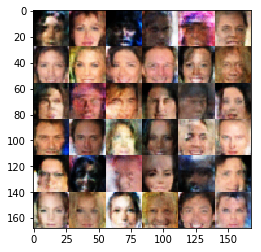

Epoch 1/1... Discriminator Loss: 1.4011... Generator Loss: 0.8188
Epoch 1/1... Discriminator Loss: 1.4768... Generator Loss: 0.4198
Epoch 1/1... Discriminator Loss: 1.2671... Generator Loss: 0.7228
Epoch 1/1... Discriminator Loss: 1.3883... Generator Loss: 0.5543
Epoch 1/1... Discriminator Loss: 1.4779... Generator Loss: 0.4470
Epoch 1/1... Discriminator Loss: 1.3262... Generator Loss: 0.4654
Epoch 1/1... Discriminator Loss: 1.5315... Generator Loss: 0.5013
Epoch 1/1... Discriminator Loss: 1.5124... Generator Loss: 1.0697
Epoch 1/1... Discriminator Loss: 1.5032... Generator Loss: 0.5343
Epoch 1/1... Discriminator Loss: 1.3834... Generator Loss: 0.6782


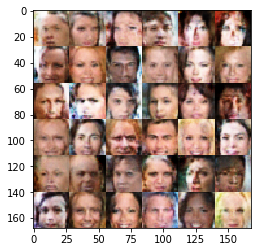

Epoch 1/1... Discriminator Loss: 1.3573... Generator Loss: 0.5715
Epoch 1/1... Discriminator Loss: 1.4091... Generator Loss: 0.5013
Epoch 1/1... Discriminator Loss: 1.4096... Generator Loss: 0.4874
Epoch 1/1... Discriminator Loss: 1.2383... Generator Loss: 1.1359
Epoch 1/1... Discriminator Loss: 1.5628... Generator Loss: 0.3976


In [ ]:
batch_size = 64
z_dim = 200
learning_rate = 0.0002
beta1 = 0.3


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 1

celeba_dataset = helper.Dataset('celeba', glob(os.path.join(data_dir, 'img_align_celeba/*.jpg')))
with tf.Graph().as_default():
    losses, samples = train(epochs, batch_size, z_dim, learning_rate, beta1, celeba_dataset.get_batches,
          celeba_dataset.shape, celeba_dataset.image_mode)

In [ ]:
fig, ax = plt.subplots()
losses = np.array(losses)
plt.plot(losses.T[0], label='Discriminator', alpha=0.5)
plt.plot(losses.T[1], label='Generator', alpha=0.5)
plt.title("Training Losses with Celeba Dataset")
plt.legend()

### Submitting This Project
When submitting this project, make sure to run all the cells before saving the notebook. Save the notebook file as "dlnd_face_generation.ipynb" and save it as a HTML file under "File" -> "Download as". Include the "helper.py" and "problem_unittests.py" files in your submission.